In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import math
from natsort import natsorted

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib import colors
from matplotlib.colors import ListedColormap

from PIL import Image, ImageDraw

from tifffile import imread

from umap import UMAP
import hdbscan
from joblib import Memory

import napari

from skimage.util import img_as_float
from skimage.color import gray2rgb

In [2]:
# INITIALLY RUN THIS SCRIPT IN IPYTHON TO UPDATE ROI SELECTIONS

In [3]:
core = '68'

In [4]:
# function for formatting color bar values
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [5]:
def categorical_cmap(numUniqueSamples, numCatagories, cmap='tab10', continuous=False):

    numSubcatagories = math.ceil(numUniqueSamples/numCatagories)

    if numCatagories > plt.get_cmap(cmap).N:
        raise ValueError('Too many categories for colormap.')
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0, 1, numCatagories))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(numCatagories, dtype=int))
        # rearrange hue order to taste
        cd = {
            'B': 0, 'O': 1, 'G': 2, 'R': 3, 'Pu': 4,
            'Br': 5, 'Pi': 6, 'Gr': 7, 'Y': 8, 'Cy': 9,
            }
        myorder = [
            cd['B'], cd['O'], cd['G'], cd['Pu'], cd['Y'],
            cd['R'], cd['Cy'], cd['Br'], cd['Gr'], cd['Pi']
            ]
        ccolors = [ccolors[i] for i in myorder]

        # use Okabe and Ito color-safe palette for first 6 colors
        # ccolors[0] = np.array([0.91, 0.29, 0.235]) #E84A3C
        # ccolors[1] = np.array([0.18, 0.16, 0.15]) #2E2926
        ccolors[0] = np.array([0.0, 0.447, 0.698, 1.0])  # blue
        ccolors[1] = np.array([0.902, 0.624, 0.0, 1.0])  # orange
        ccolors[2] = np.array([0.0, 0.620, 0.451, 1.0])  # bluish green
        ccolors[3] = np.array([0.8, 0.475, 0.655, 1.0])  # reddish purple
        ccolors[4] = np.array([0.941, 0.894, 0.259, 1.0])  # yellow
        ccolors[5] = np.array([0.835, 0.369, 0.0, 1.0])  # vermillion

    cols = np.zeros((numCatagories * numSubcatagories, 3))
    for i, c in enumerate(ccolors):
        chsv = colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv, numSubcatagories).reshape(numSubcatagories, 3)
        arhsv[:, 1] = np.linspace(chsv[1], 0.25, numSubcatagories)
        arhsv[:, 2] = np.linspace(chsv[2], 1, numSubcatagories)
        rgb = colors.hsv_to_rgb(arhsv)
        cols[i * numSubcatagories:(i + 1) * numSubcatagories, :] = rgb
    cmap = colors.ListedColormap(cols)

    # trim colors if necessary
    if len(cmap.colors) > numUniqueSamples:
        trim = len(cmap.colors) - numUniqueSamples
        cmap_colors = cmap.colors[:-trim]
        cmap = colors.ListedColormap(cmap_colors, name='from_list', N=None)

    return cmap

In [6]:
# out dir
out_dir = '../output/Fig1c'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [7]:
# read unfiltered EMIT dataset
data = pd.read_parquet('../input/Dataset3(TMA)/TMA_clean_cylinter_aggregateData.parquet')

# isolate data from target core
core_data = data[data['Sample'] == core].copy()

# read markers.csv
markers = pd.read_csv('../input/Dataset3(TMA)/markers.csv')
#'/Volumes/My Book/cylinter_input/emit22_full/markers.csv')

# isolate immunomarker channels
include = [i for i in core_data.columns if 'DNA' not in i if i in list(markers['marker_name'])]
# log-transform antibody expression data
transformed_data = np.log10(core_data[include] + 0.00001)
core_data.update(transformed_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


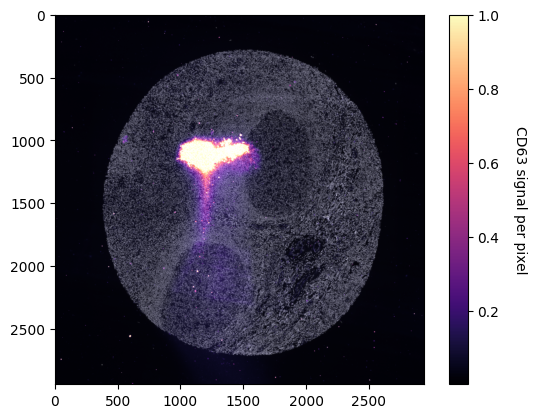

In [8]:
# crop window
row_min = 0
row_max = 2943
col_min = 0
col_max = 2943

# select cells within cropped image
data_crop = core_data[
    (core_data['X_centroid'].between(col_min, col_max)) &
    (core_data['Y_centroid'].between(row_min, row_max))
    ].copy()

# transform x, y coordinates of cells within cropped image
data_crop['X_centroid'] = data_crop['X_centroid']-col_min
data_crop['Y_centroid'] = data_crop['Y_centroid']-row_min

# read segmentation outlines of target core and crop to target size
seg = imread(f'../input/Dataset3(TMA)/seg/{core}.ome.tif', key=0)
# seg = imread(f'/Volumes/My Book/cylinter_input/emit22_full/seg/{core}.ome.tif', key=0)
seg_crop = seg[row_min:row_max, col_min:col_max].copy()

# read DNA1 image of target core and crop to target size
dna = imread(f'../input/Dataset3(TMA)/tif/{core}.ome.tif', key=0)
# dna = imread(f'/Volumes/My Book/cylinter_input/emit22_full/tif/{core}.ome.tif', key=0)
dna_float = img_as_float(dna)
dna_float = (dna_float - np.min(dna_float)) / (np.max(dna_float) - np.min(dna_float))  # normalize 0-1
dna_crop = dna_float[row_min:row_max, col_min:col_max].copy()
dna_crop_rgb = gray2rgb(dna_crop)

# read CD63 image of target core and crop to target size
cd63 = imread(f'../input/Dataset3(TMA)/tif/{core}.ome.tif', key=18)
# cd63 = imread(f'/Volumes/My Book/cylinter_input/emit22_full/tif/{core}.ome.tif', key=18)
cd63_float = img_as_float(cd63)
cd63_float = (cd63_float - np.min(cd63_float)) / (np.max(cd63_float) - np.min(cd63_float))  # normalize 0-1
cd63_crop = cd63_float[row_min:row_max, col_min:col_max].copy()

bottom_cutoff = 0.0 
top_cutoff = 0.1
cd63_crop = np.clip(cd63_crop, bottom_cutoff, top_cutoff)
cd63_crop = (cd63_crop - np.min(cd63_crop)) / (np.max(cd63_crop) - np.min(cd63_crop))  # normalize 0-1

cd63_crop_rgb = plt.cm.magma(cd63_crop) # converts to RGBA automatically
cd63_crop_rgb = cd63_crop_rgb[:, :, 0:3]  # drop alpha dimension

dna_crop_rgb /= 1.0  # dim DNA 
dna_crop_rgb += cd63_crop_rgb

# plot merged image
plt.imshow(dna_crop_rgb, cmap='magma')
plt.grid(False)
plt.savefig(os.path.join(out_dir, 'raster.png'), dpi=600)

# plt.colorbar(format=ticker.FuncFormatter(fmt))
cbar = plt.colorbar()
cbar.set_alpha(1.0)
cbar.set_label('CD63 signal per pixel', labelpad=20, rotation=270)
# plt.title(f'Core {core}')
# cbar.draw_all()
plt.savefig(os.path.join(out_dir, 'vector.pdf'))
plt.show()
plt.close('all')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


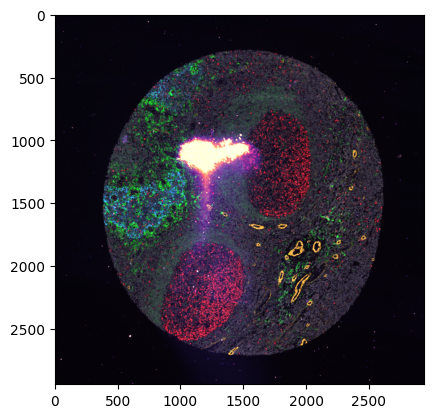

In [9]:
# re-generate DNA RGB
dna_crop_rgb = gray2rgb(dna_crop)
dna_crop_rgb /= 2.0  # dim DNA 

# re-generate CD63 RGB
cd63_crop = cd63_float[row_min:row_max, col_min:col_max].copy()
bottom_cutoff = 0.0 
top_cutoff = 0.1
cd63_crop = np.clip(cd63_crop, bottom_cutoff, top_cutoff)
cd63_crop = (cd63_crop - np.min(cd63_crop)) / (np.max(cd63_crop) - np.min(cd63_crop))  
# cd63_crop_rgb = gray2rgb(cd63_crop)
# cd63_crop_rgb *= (0.973, 0.678, 0.125)
cd63_crop_rgb = plt.cm.magma(cd63_crop) # converts to RGBA automatically
cd63_crop_rgb = cd63_crop_rgb[:, :, 0:3]  # drop alpha dimension

dna_crop_rgb += cd63_crop_rgb

# read Ki67 image of target core and crop to target size
ki67 = imread(f'../input/Dataset3(TMA)/tif/{core}.ome.tif', key=9)
# ki67 = imread(f'/Volumes/My Book/cylinter_input/emit22_full/tif/{core}.ome.tif', key=9)
ki67_float = img_as_float(ki67)
ki67_float = (ki67_float - np.min(ki67_float)) / (np.max(ki67_float) - np.min(ki67_float))  # normalize 0-1
ki67_crop = ki67_float[row_min:row_max, col_min:col_max].copy()
bottom_cutoff = 0.0 
top_cutoff = 0.3
ki67_crop = np.clip(ki67_crop, bottom_cutoff, top_cutoff)
ki67_crop = (ki67_crop - np.min(ki67_crop)) / (np.max(ki67_crop) - np.min(ki67_crop))  
ki67_crop_rgb = gray2rgb(ki67_crop)
ki67_crop_rgb *= (1.0, 0.0, 0.0)

dna_crop_rgb += ki67_crop_rgb

# read pan-CK image of target core and crop to target size
panck = imread(f'../input/Dataset3(TMA)/tif/{core}.ome.tif', key=10)
# panck = imread(f'/Volumes/My Book/cylinter_input/emit22_full/tif/{core}.ome.tif', key=10)
panck_float = img_as_float(panck)
panck_float = (panck_float - np.min(panck_float)) / (np.max(panck_float) - np.min(panck_float))  # normalize 0-1
panck_crop = panck_float[row_min:row_max, col_min:col_max].copy()
bottom_cutoff = 0.0 
top_cutoff = 0.3
panck_crop = np.clip(panck_crop, bottom_cutoff, top_cutoff)
panck_crop = (panck_crop - np.min(panck_crop)) / (np.max(panck_crop) - np.min(panck_crop))  
panck_crop_rgb = gray2rgb(panck_crop)
panck_crop_rgb *= (0.125, 0.678, 0.973)

dna_crop_rgb += panck_crop_rgb

# read aSMA image of target core and crop to target size
sma = imread(f'../input/Dataset3(TMA)/tif/{core}.ome.tif', key=14)
# sma = imread(f'/Volumes/My Book/cylinter_input/emit22_full/tif/{core}.ome.tif', key=14)
sma_float = img_as_float(sma)
sma_float = (sma_float - np.min(sma_float)) / (np.max(sma_float) - np.min(sma_float))  # normalize 0-1
sma_crop = sma_float[row_min:row_max, col_min:col_max].copy()
bottom_cutoff = 0.02 
top_cutoff = 0.4
sma_crop = np.clip(sma_crop, bottom_cutoff, top_cutoff)
sma_crop = (sma_crop - np.min(sma_crop)) / (np.max(sma_crop) - np.min(sma_crop))  
sma_crop_rgb = gray2rgb(sma_crop)
# sma_crop_rgb *= (0.580, 0.125, 0.580)  # BOP purple
sma_crop_rgb *= (0.973, 0.678, 0.125)  # BOP orange

dna_crop_rgb += sma_crop_rgb

# read CD32 image of target core and crop to target size
cd32 = imread(f'../input/Dataset3(TMA)/tif/{core}.ome.tif', key=19)
# cd32 = imread(f'/Volumes/My Book/cylinter_input/emit22_full/tif/{core}.ome.tif', key=19)
cd32_float = img_as_float(cd32)
cd32_float = (cd32_float - np.min(cd32_float)) / (np.max(cd32_float) - np.min(cd32_float))  # normalize 0-1
cd32_crop = cd32_float[row_min:row_max, col_min:col_max].copy()
bottom_cutoff = 0.02 
top_cutoff = 0.15
cd32_crop = np.clip(cd32_crop, bottom_cutoff, top_cutoff)
cd32_crop = (cd32_crop - np.min(cd32_crop)) / (np.max(cd32_crop) - np.min(cd32_crop))  
cd32_crop_rgb = gray2rgb(cd32_crop)
cd32_crop_rgb *= (0.0, 1.0, 0.0)

dna_crop_rgb += cd32_crop_rgb

plt.imshow(dna_crop_rgb, cmap='magma')
plt.grid(False)

plt.savefig(os.path.join(out_dir, 'context.png'), dpi=800)
plt.savefig(os.path.join(out_dir, 'context.pdf'))
plt.show()
plt.close('all')

In [10]:
# open target core in Napari to select ROIs if it has not already been done 
viewer = napari.view_image(dna_crop, opacity=0.5, rgb=False, name='DNA1')

viewer.add_image(
    seg_crop, rgb=False, blending='additive',
    opacity=0.5, colormap='green', visible=False,
    name='segmentation'
    )

viewer.add_image(
    cd63_crop, rgb=False, blending='additive',
    colormap='magma', visible=True,
    name='CD63'
    )

if os.path.exists(os.path.join(out_dir, f'polygon_dict_{core}.pkl')):
    f = open(os.path.join(out_dir, f'polygon_dict_{core}.pkl'), 'rb')
    polygon_dict = pickle.load(f)
    shapes = [polygon_dict[i][0] for
              i in range(0, len(polygon_dict.keys()))]
    polygons = [polygon_dict[i][1] for
              i in range(0, len(polygon_dict.keys()))]
    
    selection_layer = viewer.add_shapes(
        data=polygons,
        shape_type=shapes,
        ndim=2,
        face_color=[0.0, 1.0, 0.0, 0.0],  # [1.0, 1.0, 1.0, 0.2]
        edge_color=[0.0, 1.0, 0.0, 1.0], # [0.0, 0.66, 1.0, 1.0]
        edge_width=5.0,
        name='ROI(s)')
else:
    selection_layer = viewer.add_shapes(
        shape_type='polygon', ndim=2, face_color=[1.0, 1.0, 1.0, 0.2],
        edge_color=[0.0, 0.66, 1.0, 1.0], edge_width=10.0, name='ROI(s)'
        )

napari.run()

polygon_dict = dict(zip([i for i in range(len(selection_layer.shape_type))],
                  [i for i in zip(selection_layer.shape_type, selection_layer.data)])
              )

f = open(os.path.join(out_dir, f'polygon_dict_{core}.pkl'), 'wb')
pickle.dump(polygon_dict, f)
f.close()

In [11]:
# isolate core data within ROI bounds
roi_data = data_crop[['X_centroid', 'Y_centroid', 'CellID']].astype(int)
roi_data['tuple'] = list(zip(roi_data['X_centroid'], roi_data['Y_centroid']))

cell_ids_dict = {}

for key, (shape_type, verts) in polygon_dict.items():

    selection_verts = np.round(verts).astype(int)
    
    # create pillow image to convert into boolean mask
    img = Image.new('L', (dna_crop.shape[1], dna_crop.shape[0]))

    if shape_type == 'ellipse':
        
        vertices, triangles = triangulate_ellipse(selection_verts)
        
        # flip 2-tuple coordinates returned by
        # triangulate_ellipse() to draw image mask
        vertices = [tuple(reversed(tuple(i))) for i in vertices]

        # update pillow image with polygon
        ImageDraw.Draw(img).polygon(
            vertices, outline=1, fill=1
            )
    
    else:
        vertices = list(tuple(
            zip(selection_verts[:, 1],
                selection_verts[:, 0])
            ))

        # update pillow image with polygon
        ImageDraw.Draw(img).polygon(
            vertices, outline=1, fill=1
            )
    
    # convert pillow image into boolean numpy array
    mask = np.array(img, dtype=bool)
    
    # use numpy fancy indexing to get centroids
    # where boolean mask is True
    xs, ys = zip(*roi_data['tuple'])
    inter = mask[ys, xs]

    cell_ids = set(roi_data['CellID'][inter])
 
    cell_ids_dict[key] = cell_ids

In [12]:
# perform clustering
print('Performing UMAP embedding...')
clus_data = data_crop[include + ['CellID', 'X_centroid', 'Y_centroid']].copy()
clus_data = clus_data.sample(frac=1.0, random_state=5)
embedding = UMAP(random_state=5, min_dist=0.1, repulsion_strength=2.0).fit_transform(clus_data[include])
clus_data['emb1'] = embedding[:, 0]
clus_data['emb2'] = embedding[:, 1]

Performing UMAP embedding...


/Users/greg/venvs/cylinter/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
# assign color and size columns tp core data
clus_data['color'] = ['lime' if i in cell_ids else 'tab:gray' for i in clus_data['CellID']]
clus_data['size'] = [1.0 if i in cell_ids else 1.0 for i in clus_data['CellID']]

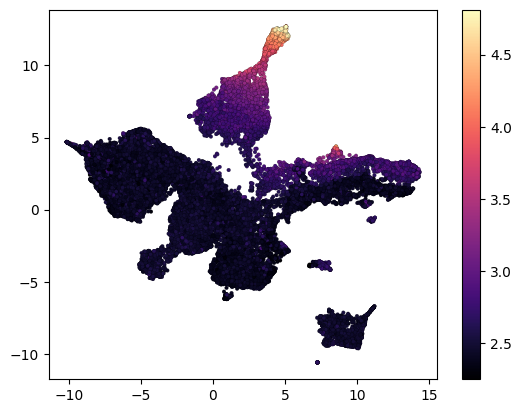

In [14]:
# plot clustering
fig, ax = plt.subplots()
sc = plt.scatter(clus_data['emb1'], clus_data['emb2'], c=clus_data['CD63'], cmap='magma', s=7.5, ec='k', lw=0.1, vmin=2.25)
plt.colorbar(sc)
ax.set_aspect('equal')
plt.savefig(os.path.join(out_dir, 'cmap.png'), dpi=1000)
plt.show()
plt.close('all')

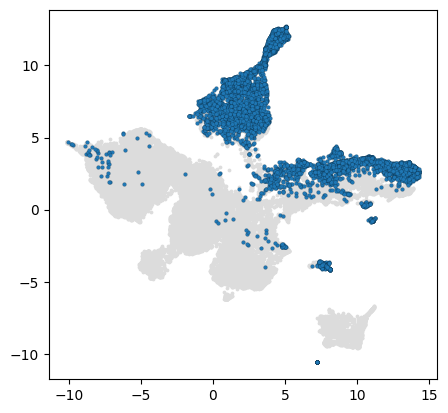

In [15]:
in_roi = clus_data[clus_data['CellID'].isin(cell_ids)]
out_roi = clus_data[~clus_data['CellID'].isin(cell_ids)]

fig, ax = plt.subplots()
plt.scatter(out_roi['emb1'], out_roi['emb2'], c='gainsboro', s=7.5, ec='k', lw=0.0, alpha=1.0)
plt.scatter(in_roi['emb1'], in_roi['emb2'], c='tab:blue', s=7.5, ec='k', lw=0.1, alpha=1.0)
ax.set_aspect('equal')
plt.savefig(os.path.join(out_dir, 'gating.png'), dpi=1000)
plt.show()
plt.close('all')

30208 cells


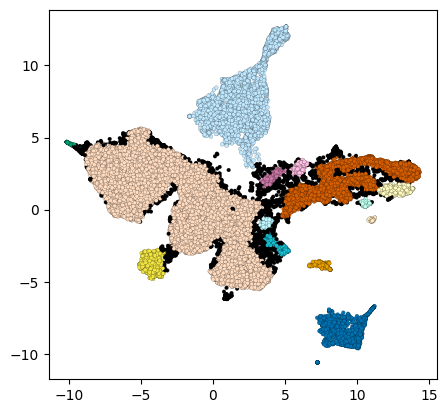

In [16]:
clustering = hdbscan.HDBSCAN(min_cluster_size=70).fit(clus_data[['emb1', 'emb2']])
clus_data['cluster'] = clustering.labels_
print(f'{len(clus_data)} cells')

# generate categorical cmap for clusters
cmap = categorical_cmap(
    numUniqueSamples=len(clus_data['cluster'].unique()),
    numCatagories=10, cmap='tab10', continuous=False)

cmap = ListedColormap(
    np.insert(
        arr=cmap.colors, obj=0,
        values=[0, 0, 0], axis=0)
        )

# trim cmap to # unique samples
trim = (
    len(cmap.colors) - len(
        clus_data['cluster'].unique())
    )
cmap = ListedColormap(
    cmap.colors[:-trim]
    )

sample_dict = dict(
    zip(
        natsorted(
            clus_data['cluster'].unique()),
        list(range(len(clus_data['cluster']
             .unique()))))
        )

c = [sample_dict[i] for i
     in clus_data['cluster']]

fig, ax = plt.subplots()
plt.scatter(clus_data['emb1'], clus_data['emb2'], c=c, cmap=cmap, s=7.5, ec='k', lw=0.1, alpha=1.0)
ax.set_aspect('equal')
plt.savefig(os.path.join(out_dir, 'clustering.png'), dpi=1000)
plt.show()
plt.close('all')